<a href="https://colab.research.google.com/github/Adrianosh3/NeuronaleNetze/blob/Elisa/NN_transferlearning_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
from google.colab import drive
drive.mount('/content/Drive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import os
import copy
import glob
import time
from pathlib import Path

import PIL
from PIL import Image


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [58]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan  3 18:23:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |   4507MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [59]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [60]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.10.0+cu111  Device: cuda


In [61]:
#Paramter des Netzes
NUM_ClASSES = 2
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
NUM_EPOCHS = 5
BATCH_SIZE = 12

In [62]:
#Daten laden
import zipfile
with zipfile.ZipFile('/content/Drive/MyDrive/HA_NN/dogs-vs-cats.zip') as entire_zip:
     entire_zip.extractall('.')
with zipfile.ZipFile('./train.zip') as train_zip:
     train_zip.extractall('.')

train_dir = './train'

In [63]:
def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]

In [64]:
class DogVsCatDataset(Dataset):
  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
  
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
    
        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0
    
        return image, label

In [65]:
Img_dir = glob.glob(os.path.join(train_dir, '*.jpg'))
x_train ,x_val = train_test_split(Img_dir,test_size=0.2,random_state=42)

In [66]:
from torchvision.transforms.transforms import RandomRotation
image_dir = '/content/Drive/MyDrive/HA_NN/dogs-vs-cats/train/'

transform_test = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])

transform_Val = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])

x_train ,x_val = train_test_split(Img_dir,test_size=0.2) 

train_dataset  = DogVsCatDataset(x_train, transform= transform_test)
validation_dataset = DogVsCatDataset(x_val, transform= transform_Val)

print('Anzahl Daten: ',len(Img_dir))
print('Anzahl Train_Daten: ',len(train_dataset))
print('Anzahl Validierungs_Daten: ',len(validation_dataset))

Anzahl Daten:  25000
Anzahl Train_Daten:  20000
Anzahl Validierungs_Daten:  5000


In [67]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

Anzahl train_loader:  1667
Anzahl val_loader:  417


In [68]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in validation_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([12, 3, 224, 224])
Image label dimensions: torch.Size([12])
Image batch dimensions: torch.Size([12, 3, 224, 224])
Image label dimensions: torch.Size([12])


In [69]:
classes = ('Cat', 'Dog')

train
val


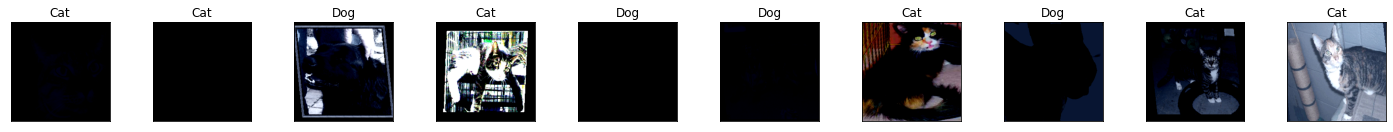

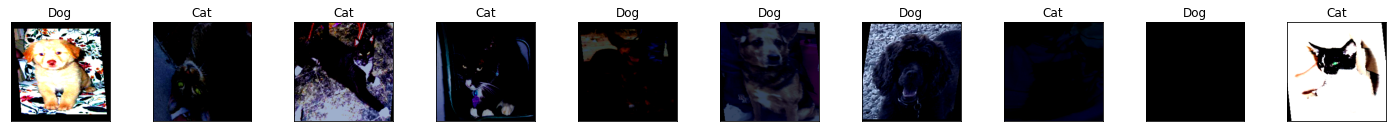

In [84]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

print('train')
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

print('val')
dataiter_val = iter(validation_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [71]:
#Loading pretrained model
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [72]:
for param in model.features.parameters():
  param.requires_grad = False

In [73]:
model.classifier[6] = nn.Sequential(nn.Linear(4096, NUM_ClASSES))
model_CNN=model.to(device)
print(model_CNN)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [74]:
from torchsummary import summary
summary (model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [75]:
#Loss
criterion = nn. CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [76]:
def train_val(epoch, train_loss_history,train_corrects_history,val_loss_history,val_corrects_history):
    train_loss = 0.0
    train_corrects = 0.0
    val_loss = 0.0
    val_corrects = 0.0


    since = time.time()
    best_acc = 0.0
    
    best_model_wts = copy.deepcopy(model_CNN.state_dict())
    model_CNN.train()
        
    for batch_idx, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_predicted = model_CNN(x_train)
      
        optimizer.zero_grad() 

        loss = criterion(y_predicted, y_train)

        loss.backward()
        
        optimizer.step()
        
        _, preds = torch.max(y_predicted, 1)
        train_loss += loss.item()
        train_corrects += torch.sum(preds == y_train.data)
        
    else:
        with torch.no_grad():
          for  x_val, y_val in validation_loader:
           

            x_val = x_val.to(device)
            y_val = y_val.to(device)
            val_outputs = model_CNN(x_val)

            val_loss = criterion(val_outputs, y_val)

            _, val_preds = torch.max(val_outputs, 1)
            val_loss += val_loss.item()
            val_corrects += torch.sum(val_preds == y_val.data)

        epoch_loss = train_loss/len(train_loader.dataset)
        epoch_acc = train_corrects.float()/ len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_corrects_history.append(epoch_acc)

        val_epoch_loss = val_loss/len(validation_loader.dataset)
        val_epoch_acc = val_corrects.float()/ len(validation_loader.dataset)


        if val_epoch_acc > best_acc:
          best_acc = val_epoch_acc
          best_model_wts = copy.deepcopy(model_CNN.state_dict())


        val_loss_history.append(val_epoch_loss)
        val_corrects_history.append(val_epoch_acc)
        print('epoch :', (epoch+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item())) 

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        model_CNN.load_state_dict(best_model_wts)

In [77]:
train_loss_history = []
train_corrects_history = []
val_loss_history = []
val_corrects_history = []
for epoch in range(NUM_EPOCHS):
    train_val(epoch,train_loss_history,train_corrects_history,val_loss_history,val_corrects_history)

epoch : 1
training loss: 0.0156, acc 0.9172 
validation loss: 0.0000, validation acc 0.9870 
Training complete in 4m 35s
Best val Acc: 0.987000
epoch : 2
training loss: 0.0125, acc 0.9323 
validation loss: 0.0000, validation acc 0.9860 
Training complete in 4m 36s
Best val Acc: 0.986000
epoch : 3
training loss: 0.0119, acc 0.9372 
validation loss: 0.0000, validation acc 0.9864 
Training complete in 4m 35s
Best val Acc: 0.986400
epoch : 4
training loss: 0.0114, acc 0.9389 
validation loss: 0.0000, validation acc 0.9862 
Training complete in 4m 36s
Best val Acc: 0.986200
epoch : 5
training loss: 0.0110, acc 0.9390 
validation loss: 0.0000, validation acc 0.9860 
Training complete in 4m 37s
Best val Acc: 0.986000


Hier drüber ggf. ihren Code nehmen?

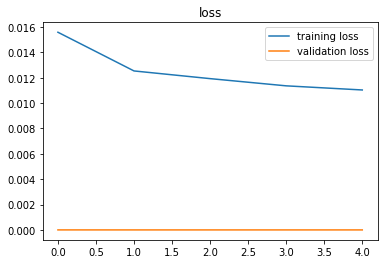

In [78]:
plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()
plt.title('loss')
plt.savefig('/content/Drive/MyDrive/HA_NN/Loss_V00.png')

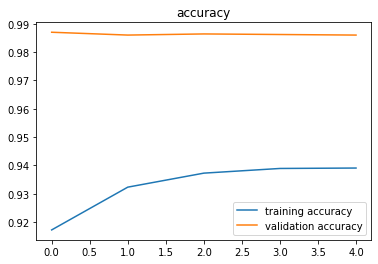

In [79]:
plt.plot(train_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()
plt.title('accuracy')
plt.savefig('/content/Drive/MyDrive/HA_NN/Accuracy_V00.png')

In [80]:
from sklearn.metrics import confusion_matrix
x_val,y_val = next(iter(validation_loader))
y_pred = model_CNN(x_val.to(device))
y_val = y_val.to('cpu')
y=y_pred.data.max(1)[1].to('cpu')
Conf_Mat = confusion_matrix(y,y_val)

for i in range(len(validation_loader)-1):
    x_val,y_val = next(iter(validation_loader))
    y_pred = model_CNN(x_val.to(device))
    y_val = y_val.to('cpu')
    y=y_pred.data.max(1)[1].to('cpu')
    Conf_Mat += confusion_matrix(y,y_val)
print("Confusion Matrix : ")

Conf_Mat

Confusion Matrix : 


array([[2085,  357],
       [   0, 2562]])

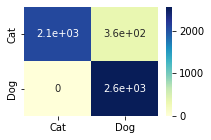

In [81]:
import seaborn as sn
df_cm = pd.DataFrame(Conf_Mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (3,2))
sn.heatmap(df_cm,cmap="YlGnBu",annot=True)#,fmt='.2%')
plt.savefig('/content/Drive/MyDrive/HA_NN/ConfMat_V00.png')

In [82]:
model_save_name = 'CNN_catdog.pt'
path = F"/content/Drive/MyDrive/Hausarbeit NN/{model_save_name}" 
torch.save(model_CNN.state_dict(), path)

In [83]:
model_CNN_2 = torch.load(path)
model_CNN_2

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3